In [1]:
## Standard Libraries

In [2]:
%matplotlib inline

In [3]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np

## Vision stuff

In [4]:
from LogGabor import LogGabor

## Pierre's stuff

In [5]:
# TODO: passer les arguments par la ligne de commande
N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho = 6, 12, 8, 2, 128, 128, 1.41
verbose = 1
OFFSET_STD = 10
OFFSET_MAX = 25

#### Charger la matrice de certitude

In [6]:
path = "../data/MNIST_accuracy.npy"
if os.path.isfile(path):
    accuracy =  np.load(path)
    if verbose:
        print('Loading accuracy... min, max=', accuracy.min(), accuracy.max())
else:
    print('No accuracy data found.')


Loading accuracy... min, max= 0.0145 0.9852


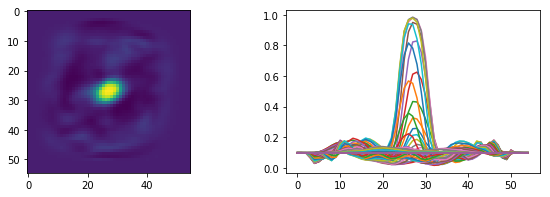

In [7]:
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(accuracy)
plt.subplot(122)
_ = plt.plot(accuracy)

### Encoding : N_theta x N_azimuth x N_eccentricity x N_phase  2D filters (to be applied on N_X x N_Y pixels)

#### Préparer l'apprentissage et les fonctions nécessaires au fonctionnement du script

In [8]:
def vectorization(N_theta=N_theta, N_azimuth=N_azimuth, N_eccentricity=N_eccentricity, N_phase=N_phase, \
                  N_X=N_X, N_Y=N_Y, rho=rho, ecc_max=.8, B_sf=.4, B_theta=np.pi/N_theta/2):
    retina = np.zeros((N_theta, N_azimuth, N_eccentricity, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    # params = {'sf_0': .1, 'B_sf': lg.pe.B_sf,
    #           'theta': np.pi * 5 / 7., 'B_theta': lg.pe.B_theta}
    # phase = np.pi/4
    # edge = lg.normalize(lg.invert(lg.loggabor(
    #     N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

    for i_theta in range(N_theta):
        for i_azimuth in range(N_azimuth):
            for i_eccentricity in range(N_eccentricity):
                ecc = ecc_max * (1/rho)**(N_eccentricity - i_eccentricity)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc  # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * \
                    np.cos((i_azimuth+(i_eccentricity % 2)*.5)*np.pi*2 / N_azimuth)
                y = N_Y/2 + r * \
                    np.sin((i_azimuth+(i_eccentricity % 2)*.5)*np.pi*2 / N_azimuth)
                for i_phase in range(N_phase):
                    params = {'sf_0': sf_0, 'B_sf': B_sf,
                              'theta': i_theta*np.pi/N_theta, 'B_theta': B_theta}
                    phase = i_phase * np.pi/2
                    # print(r, x, y, phase, params)

                    retina[i_theta, i_azimuth, i_eccentricity, i_phase, :] = lg.normalize(
                        lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()


    return retina


#### Full encoding

In [9]:
retina = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)
print(retina.shape)

(6, 12, 8, 2, 16384)


In [10]:
retina_vector = retina.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
print(retina_vector.shape)

(1152, 16384)


In [11]:
retina_inverse = np.linalg.pinv(retina_vector)
print(retina_inverse.shape)

(16384, 1152)


#### Orientation invariant power encoding (colliculus??)

In [12]:
colliculus = (retina**2).sum(axis=(0, 3))
colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

(12, 8, 16384)


In [13]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

(96, 16384)


In [14]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

(16384, 96)


In [ ]:
energy = (retina**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_azimuth):
    for i_scale in range(N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/N_azimuth)])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

### From MNIST encoding

#### Input vectors encoding

In [15]:
def mnist_fullfield(data, i_offset, j_offset, N_pic=N_X, noise=0.,  contrast=1.):
    N_stim = data.shape[0]
    center = (N_pic-N_stim)//2

    data_fullfield = (data.min().numpy()) * np.ones((N_pic, N_pic))
    data_fullfield[int(center+i_offset):int(center+N_stim+i_offset), int(center+j_offset):int(center+N_stim+j_offset)] = data

    # data normalization
    # data_fullfield -= data_fullfield.mean()
    # data_fullfield /= data_fullfield.std()
    # data_fullfield *= std
    # data_fullfield += mean
    data_fullfield = (data_fullfield - data_fullfield.min())/(data_fullfield.max() - data_fullfield.min())
    data_fullfield *= contrast

    if noise>0.:
        data_fullfield += noise * MotionCloudNoise()

    data_retina = retina_vector @ np.ravel(data_fullfield)

    return data_retina

#### Output vectors (Accuracy/Saliency map) encoding

In [16]:
def accuracy_fullfield(accuracy, i_offset, j_offset, N_pic=N_X):
    N_stim = accuracy.shape[0]
    center = (N_pic-N_stim)//2

    accuracy_fullfield = 0.1 * np.ones((N_pic, N_pic))
    accuracy_fullfield[int(center+i_offset):int(center+N_stim+i_offset),
                 int(center+j_offset):int(center+N_stim+j_offset)] = accuracy

    accuracy_colliculus = colliculus_vector @ np.ravel(accuracy_fullfield)

    return accuracy_colliculus

#### Utilitaires

In [17]:
def couples(data, i_offset, j_offset, contrast=1.): #, device):
    #data = data.to(device)
    v = mnist_fullfield(data, i_offset, j_offset, contrast=contrast)
    a = accuracy_fullfield(accuracy, i_offset, j_offset)
    return (v, a)

In [18]:
def minmax(value, border):
    value = max(value, -border)
    value = min(value, border)
    return int(value)

In [19]:
def MotionCloudNoise(sf_0=0.125, B_sf=3.):
    mc.N_X, mc.N_Y, mc.N_frame = 128, 128, 1
    fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
    name = 'static'
    env = mc.envelope_gabor(fx, fy, ft, sf_0=sf_0, B_sf=B_sf, B_theta=np.inf, V_X=0., V_Y=0., B_V=0, alpha=.5)
    z = mc.rectif(mc.random_cloud(env))
    z = z.reshape((mc.N_X, mc.N_Y))

## Torch libraries

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

#### Hyperparameters

In [134]:
minibatch_size = 100  # quantity of examples that'll be processed
lr = 1e-3 #0.05

n_hidden1 = 200 #80
n_hidden2 = 80 #200

print('n_hidden1', n_hidden1, ' / n_hidden2', n_hidden2)
verbose = 1
mean, std = 0.13,  .3
mean, std = 0.,  .3
train = True

n_hidden1 200  / n_hidden2 80


#### Torch stuff

In [106]:
do_cuda = False # torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if do_cuda else {}
device = torch.cuda.device("cuda" if do_cuda else "cpu")

In [107]:
#### MNIST dataset read out

In [108]:
def get_data_loader(mean=mean, std=std, batch_size=minibatch_size, train=train):
    data_loader = torch.utils.data.DataLoader(
        datasets.MNIST('/tmp/data',
                       train=train,     # def the dataset as training data
                       download=True,  # download if dataset not present on disk
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0,), std=(1,))])),
                       batch_size=batch_size,
                       shuffle=True, **kwargs)
    return data_loader


In [109]:
train_loader = get_data_loader(mean=mean, std=std, batch_size=minibatch_size, train = True)
test_loader = get_data_loader(mean=mean, std=std, batch_size=10000, train = False)

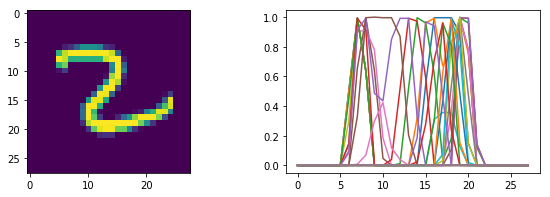

In [110]:
data, label = next(iter(train_loader))
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(data[0,0,:,:])
plt.subplot(122)
_ = plt.plot(data[0,0,:,:])

#### Network

In [111]:
class Net(torch.nn.Module):
    
    def __init__(self, n_feature, n_hidden1, n_hidden2, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.predict = torch.nn.Linear(n_hidden2, n_output)
        #self.dropout = nn.Dropout(p = 0.5) 
        
    def forward(self, data, do_leaky_relu=True):
        data = F.relu(self.hidden1(data))
        data = F.relu(self.hidden2(data))
        data = F.dropout(data, p = .5) #self.dropout)
        data =  self.predict(data)
        return data


In [112]:
net = Net(n_feature=N_theta*N_azimuth*N_eccentricity*N_phase,\
          n_hidden1=n_hidden1,\
          n_hidden2=n_hidden2,\
          n_output=N_azimuth*N_eccentricity)

In [113]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [135]:
#loss_func = torch.nn.MSELoss() 
loss_func = torch.nn.BCEWithLogitsLoss()

In [136]:
#### Training

In [137]:
def train(net, minibatch_size, \
          optimizer=optimizer, \
          vsize = N_theta * N_azimuth * N_eccentricity * N_phase,\
          asize = N_azimuth * N_eccentricity, \
          offset_std=OFFSET_STD, \
          offset_max=OFFSET_MAX, \
          verbose=1, \
          contrast=std):
    
    t_start = time.time()
    
    if verbose: print('Starting training...')
    
    for batch_idx, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()

        input_ = np.zeros((minibatch_size, 1, vsize))
        a_data = np.zeros((minibatch_size, 1, asize))
        # target = np.zeros((minibatch_size, asize))

        for idx in range(minibatch_size):
            i_offset = minmax(np.random.randn() * offset_std, offset_max)
            j_offset = minmax(np.random.randn() * offset_std, offset_max)
            input_[idx, 0, :], a_data[idx, 0, :] = couples(data[idx, 0, :, :], i_offset, j_offset, contrast=contrast)

        #input_, target = Variable(torch.FloatTensor(input_)), Variable(torch.FloatTensor(a_data))
        input_, a_data = Variable(torch.FloatTensor(input_)), Variable(torch.FloatTensor(a_data))
        #input_, a_data = input_.to(device), a_data.to(device)
        #print('a_data.numpy()', a_data.numpy().shape)
        #print('... min, max=', a_data.numpy().min(), a_data.numpy().max())
        prediction = net(input_)
        #loss = loss_func(prediction, target)
        loss = loss_func(prediction, a_data)


        #input_, target = Variable(torch.FloatTensor(input_)), Variable(torch.FloatTensor(a_data))
        # input_, target = Variable(torch.FloatTensor(input_)), Variable(torch.FloatTensor(target))
        # data, target = data.to(self.device), target.to(self.device)

        # prediction = net(input_)
        # loss = loss_func(prediction, target)

        loss.backward()
        optimizer.step()

        if verbose and batch_idx % 10 == 0:
            print('[{}/{}] Loss: {} Time: {:.2f} mn'.format(
                batch_idx*minibatch_size, len(train_loader.dataset),
                loss.data.numpy(), (time.time()-t_start)/60))
    return net


In [138]:
def test(net, minibatch_size, optimizer=optimizer,
         vsize=N_theta*N_azimuth*N_eccentricity*N_phase,
         asize=N_azimuth*N_eccentricity, offset_std=OFFSET_STD, offset_max=OFFSET_MAX):
    #for batch_idx, (data, label) in enumerate(test_loader):
    data, label = next(iter(test_loader))
    
    input_, a_data = np.zeros((minibatch_size, 1, vsize)), np.zeros(
        (minibatch_size, 1, asize))
    target = np.zeros((minibatch_size, asize))
    for idx in range(minibatch_size):
        i_offset, j_offset = minmax(np.random.randn()*offset_std, offset_max), minmax(np.random.randn()*offset_std, offset_max)
        input_[idx, 0, :], a_data[idx, 0, :] = couples(data[idx, 0, :], i_offset, j_offset)
        target[idx, :] = a_data[idx, 0, :]

    input_ = Variable(torch.FloatTensor(input_))
    target = Variable(torch.FloatTensor(a_data))

    prediction = net(input_)
    loss = loss_func(prediction, target)

    return loss.data.numpy()


In [185]:
for epoch in range(1, 100):
    train(net, minibatch_size)
    Accuracy = test(net, minibatch_size)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 0.37173378467559814 Time: 0.03 mn
[1000/60000] Loss: 0.3691807985305786 Time: 0.26 mn
[2000/60000] Loss: 0.37061968445777893 Time: 0.51 mn
[3000/60000] Loss: 0.37635475397109985 Time: 0.76 mn
[4000/60000] Loss: 0.37561291456222534 Time: 1.03 mn
[5000/60000] Loss: 0.37190550565719604 Time: 1.27 mn
[6000/60000] Loss: 0.37026143074035645 Time: 1.53 mn
[7000/60000] Loss: 0.37213361263275146 Time: 1.81 mn
[8000/60000] Loss: 0.36903679370880127 Time: 2.07 mn
[9000/60000] Loss: 0.37118279933929443 Time: 2.31 mn
[10000/60000] Loss: 0.36843690276145935 Time: 2.54 mn
[11000/60000] Loss: 0.3676808178424835 Time: 2.77 mn
[12000/60000] Loss: 0.3706570565700531 Time: 3.01 mn
[13000/60000] Loss: 0.36943885684013367 Time: 3.24 mn
[14000/60000] Loss: 0.36922553181648254 Time: 3.47 mn
[15000/60000] Loss: 0.37401679158210754 Time: 3.71 mn
[16000/60000] Loss: 0.368516743183136 Time: 3.95 mn
[17000/60000] Loss: 0.36912089586257935 Time: 4.19 mn
[18000/60000] Loss: 0.368

KeyboardInterrupt: 

In [186]:
Accuracy = test(net, minibatch_size)
print(Accuracy) # print que le pourcentage de réussite final

0.5444014668464661


In [187]:
vsize = N_theta * N_azimuth * N_eccentricity * N_phase
asize = N_azimuth * N_eccentricity
offset_std=OFFSET_STD
offset_max=OFFSET_MAX

data, label = next(iter(test_loader))
input_ = np.zeros((minibatch_size, 1, vsize))
a_data = np.zeros((minibatch_size, 1, asize))
        # target = np.zeros((minibatch_size, asize))

for idx in range(minibatch_size):
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    input_[idx, 0, :], a_data[idx, 0, :] = couples(data[idx, 0, :, :], i_offset, j_offset, contrast=std)

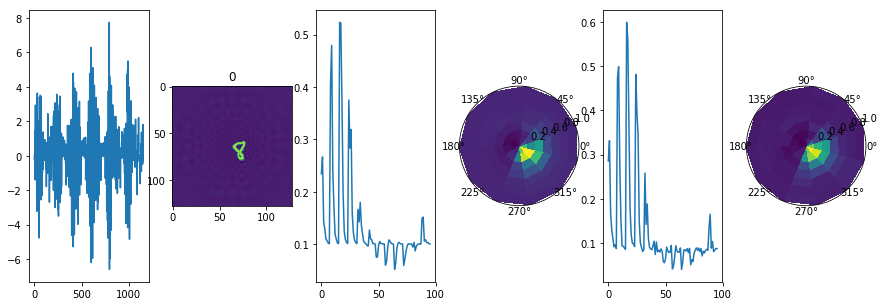

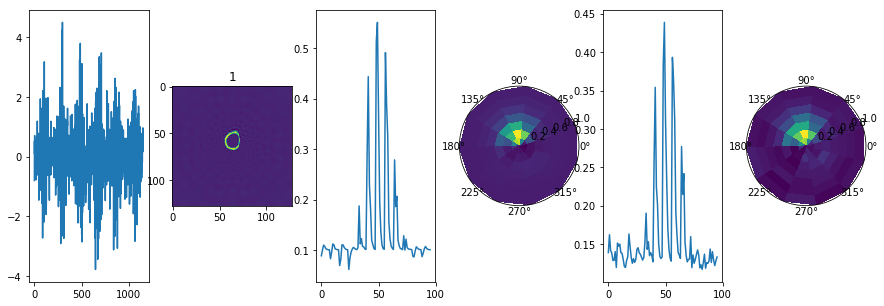

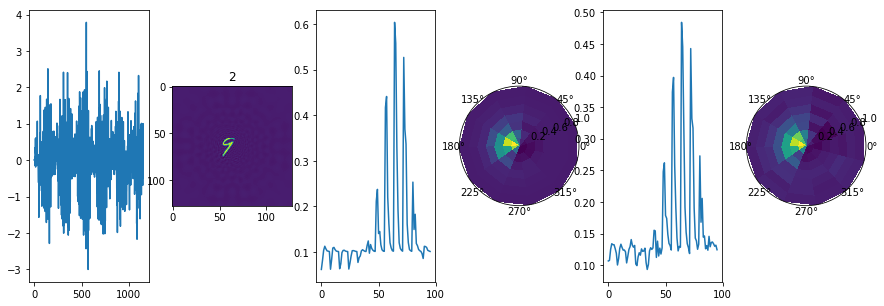

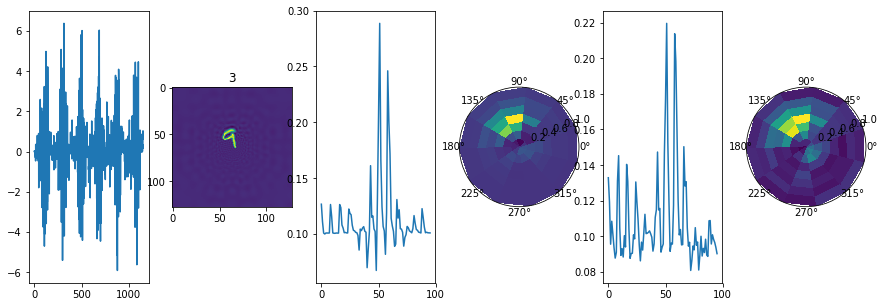

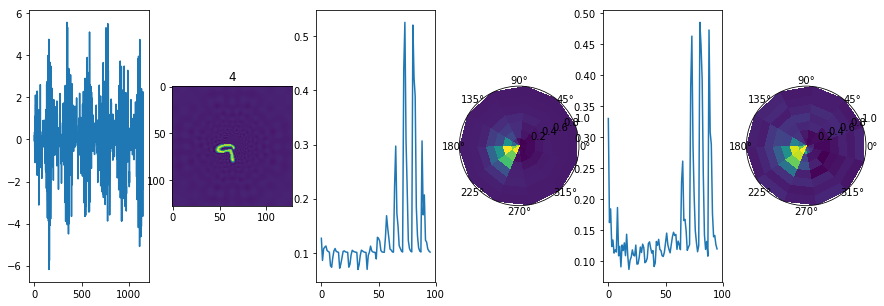

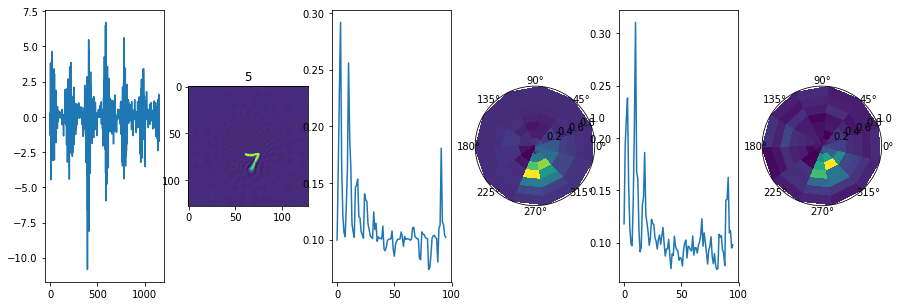

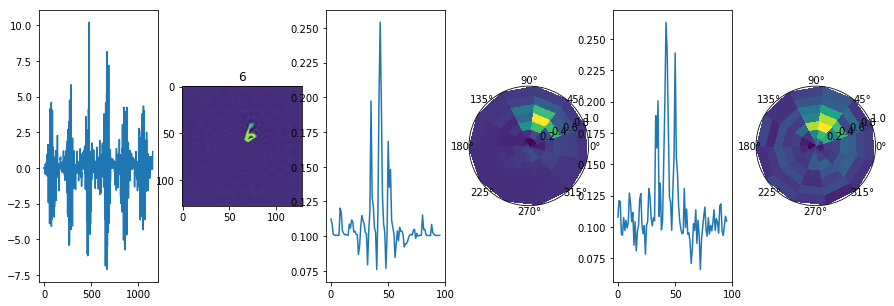

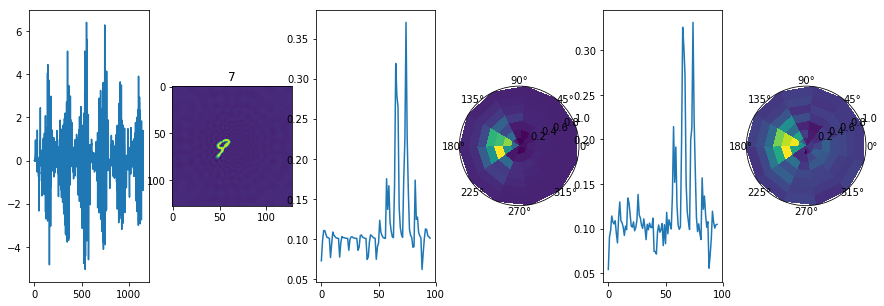

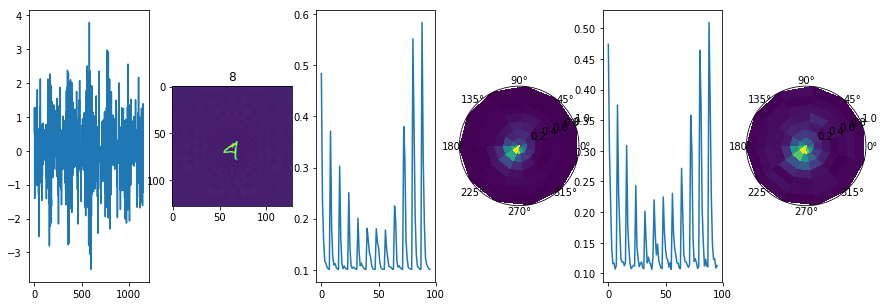

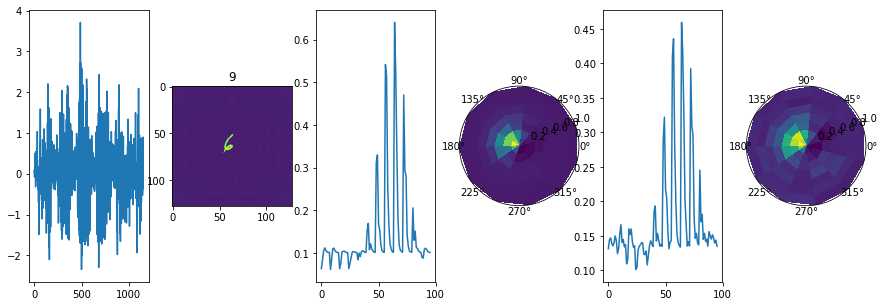

In [195]:
delta = 1/N_azimuth
log_r, theta = np.meshgrid(np.linspace(0, 1, N_eccentricity + 1), np.linspace(-np.pi*(.5 + delta), np.pi*(1.5 - delta), N_azimuth + 1))
for _ in range(10):
    im = retina_inverse @ input_[_,0,:]
    plt.figure(figsize = (15, 5))
    plt.subplot(161)
    plt.plot(input_[_,0,:])
    plt.subplot(162)
    plt.imshow(im.reshape(128, 128))
    plt.title(_)
    plt.subplot(163)
    plt.plot(a_data[_,0,:])    
    col = colliculus_inverse @ a_data[_,0,:]
    ax = plt.subplot(164, projection='polar')
    vec = a_data[_,0,:]
    ax.pcolor(theta, log_r, vec.reshape((12, 8)))
    #plt.imshow(col.reshape(128, 128))
    in_ = Variable(torch.FloatTensor(input_[_,0,:]))
    out = net(in_)
    plt.subplot(165)
    out_sig = F.sigmoid(out).detach().numpy()
    plt.plot(out_sig)    
    view = colliculus_inverse @ out_sig
    ax = plt.subplot(166, projection='polar')
    ax.pcolor(theta, log_r, out_sig.reshape((12, 8)))
    #plt.imshow(view.reshape(128, 128))
                                 